# Import Statements

In [1]:
!pip install matplotlib
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
"""
These are our import statements
"""

import numpy as np
import matplotlib.pyplot as plt
import statistics
import random
import time  # Importing time module for tracking elapsed time
from sklearn.svm import LinearSVC  # Import the SVM classifier
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [3]:
url = 'https://raw.githubusercontent.com/jamiehadd/QuantileRKIandPerceptron/refs/heads/main/functions_QRK.py'
!wget --no-cache --backups=1 {url}
from functions_QRK import perceptronModified

--2025-04-19 14:42:43--  https://raw.githubusercontent.com/jamiehadd/QuantileRKIandPerceptron/refs/heads/main/functions_QRK.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2693 (2.6K) [text/plain]
Failed to rename functions_QRK.py to functions_QRK.py.1: (2) No such file or directory
Saving to: ‘functions_QRK.py’

functions_QRK.py    100%[===================>]   2.63K  --.-KB/s    in 0s      

2025-04-19 14:42:44 (36.6 MB/s) - ‘functions_QRK.py’ saved [2693/2693]



# $\beta = 0.01$ Experiments



# Synthesize the normally distributed data set

In [4]:
numDataPoints = 50000
numFeatures = 100
data = np.random.normal(0, 1, size=(numFeatures, numDataPoints))  # Mean=0, S.D. = 1, generates a 100x50000 array
# Normalize the data
for i in range(data.shape[1]):
    data[:, i] = data[:, i] / np.linalg.norm(data[:, i])

In [5]:
# True decision boundary separating the 2 classes of data
w_true = np.random.normal(0, 1, size=(numFeatures, 1))

# Identify points on either side of the line {x: w_true^T x = 0}
labels = np.zeros((1, data.shape[1]))
for col_ind in range(data.shape[1]):
    if np.dot(data[:, col_ind], w_true) < 0:
        labels[0, col_ind] = -1
    else:
        labels[0, col_ind] = 1

correct_labels = labels.copy()
# Create a dictionary with the data points and their labels
original_data_dict = {}
for i in range(data.shape[1]):
    key = tuple(data[:, i])
    value = labels[0, i]
    original_data_dict[key] = value

In [6]:
'''Mislabel points'''

# Number of mislabelled points
numMislabelled = 500

fraction_corrupted = numMislabelled / data.shape[1]
print(f"Fraction corrupted: {fraction_corrupted}")

indices = np.where(labels[0] == 1)[0]

# Mislabel the first `numMislabelled` points from the positive class
mislabelled_indices = indices[:numMislabelled]
labels[0, mislabelled_indices] = -1

# Now, create a dictionary that includes all data points with their possibly mislabelled labels
mislabelled_data_dict = {}

# Store the mislabelled data points in the dictionary
for i in range(data.shape[1]):
    key = tuple(data[:, i])  # Use tuple of the data point as the key
    value = labels[0, i]  # Corresponding label (either 1 or -1)
    mislabelled_data_dict[key] = value

mislabelled_points = {key: value for key, value in mislabelled_data_dict.items() if value == -1}
new_labels = np.array(list(original_data_dict.values()))

Fraction corrupted: 0.01


In [7]:
correct_labels = correct_labels.reshape(-1) # essential line to reshape array
labels = labels.reshape(-1) # essential line to reshape array

In [8]:
y_test = correct_labels
X_train, y_train = data.T, labels
svm_model = LinearSVC(dual=False)
svm_model.fit(X_train, y_train)
w = svm_model.coef_[0]
b = svm_model.intercept_[0]
# Manually calculate predictions for X_test using the decision function
y_pred = np.sign(np.dot(X_train, w) + b)  # Decision function: w * X + b
difference_mask = np.where(correct_labels == labels)  # Only retain the spots where they are equal
y_predUncorrupted = y_pred[difference_mask]
y_testUncorrupted = y_test[difference_mask]
# Now compare these predictions to the true labels (y_test)
accuracy = accuracy_score(y_predUncorrupted, y_testUncorrupted)
# Print results
print("Manual predictions:", y_predUncorrupted)
print("True labels (y_test):", y_testUncorrupted)
print("Accuracy:", accuracy)

Manual predictions: [-1. -1. -1. ... -1. -1. -1.]
True labels (y_test): [-1. -1. -1. ... -1. -1. -1.]
Accuracy: 0.9848080808080808


# Function call and error plot

In [9]:
quantile_list = [0.9, 0.95, 0.99, 1]
residual_list = []

numTrials = 5
numIterations = 25000
for q in quantile_list:
  intermediateResiduals = []
  for i in range(numTrials):
      x, residuals, _ = perceptronModified(data, labels, q, numDataPoints, numIterations, correct_labels, numMislabelled, numDataPoints)
      intermediateResiduals.append(residuals)
  intermediateResiduals = np.mean(intermediateResiduals, axis = 0)
  residual_list.append(intermediateResiduals)  # Store residuals for each quantile

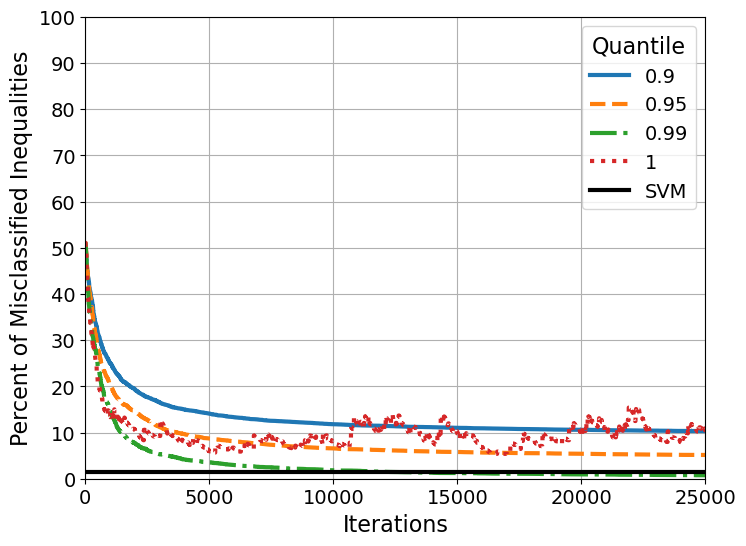

In [10]:
line_styles = ['-', '--', '-.', ':']
plt.figure(figsize=(8, 6))

# Plot residual curves
for idx, residuals in enumerate(residual_list):
    x = np.arange(len(residuals))
    plt.plot(x, residuals, label=f'{quantile_list[idx]}', linestyle=line_styles[idx], linewidth=3)

# Plot horizontal line at 1 - accuracy (in percent)
plt.axhline(y=(1 - accuracy) * 100, color='black', linestyle='-', linewidth=3, label='SVM')

# Formatting
plt.xlim(0, numIterations)
plt.ylim(bottom=0)
plt.yticks(np.arange(0, 110, 10), fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Quantile', fontsize=14, title_fontsize=16)
plt.grid(True)

# Save and show
plt.savefig('beta_equals_0.01.png', dpi=300, bbox_inches='tight')
plt.show()

# Sampled Indices: Timing them



In [11]:
sampled_indices_list = [1000, 25000, 50000]

In [12]:
residual_list = []  # Residual times for each sampled index
residual_errors = []  # Residual errors for each sampled index
residual_dict = {}  # Dictionary to store residual_list for each t value
error_dict = {}  # Dictionary to store residual_errors for each t value
q = 1-fraction_corrupted
trials = 5
numIters = 25000

for t in sampled_indices_list:
    residual_list_i = []
    residual_errors_i = []
    for i in range(trials):
        x, residuals, residuals_time = perceptronModified(data, labels, q, t, numIters, correct_labels, numMislabelled, numDataPoints)
        residual_list_i.append(residuals_time)
        residual_errors_i.append(residuals)
    # Average the results for this sampled index across the iterations
    avg_residual_time = np.mean(residual_list_i, axis=0)
    avg_residual_error = np.mean(residual_errors_i, axis=0)

    # Append to the overall list
    residual_list.append(avg_residual_time)
    residual_errors.append(avg_residual_error)

    # Store the average residual times and errors for this t value in the corresponding dictionaries
    residual_dict[t] = avg_residual_time
    error_dict[t] = avg_residual_error

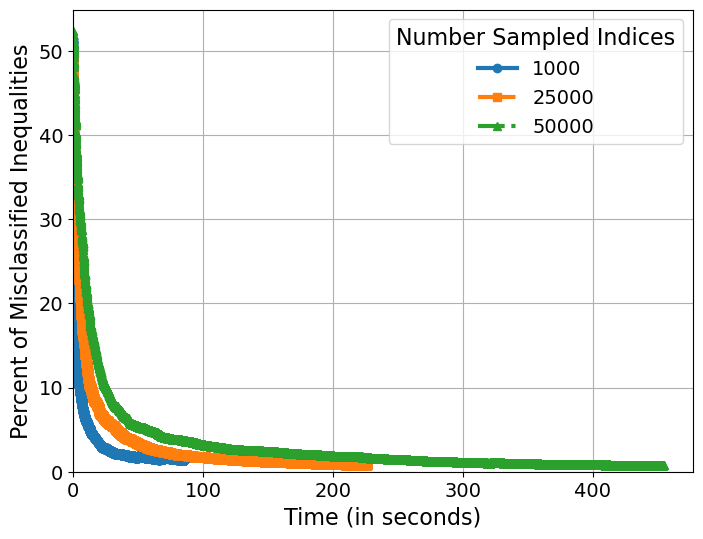

In [13]:
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(8, 6))
for idx, t in enumerate(sampled_indices_list):
    x_values = residual_dict[t]
    y_values = error_dict[t]
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    plt.plot(x_values, y_values, label=f'{t}', linestyle=line_style, marker=marker, linewidth=3)

plt.xlabel('Time (in seconds)', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Number Sampled Indices', fontsize=14, title_fontsize=16, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, which='both', axis='both')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.savefig('time_sampled_indices_q_equals_0.99.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()

# $\beta = 0.05$ Experiments


# Synthesize the normally distributed data set

In [14]:
# Synthesize 2D data points and normalize them
numDataPoints = 50000
numFeatures = 100
data = np.random.normal(0, 1, size=(numFeatures, numDataPoints))  # Mean=0, S.D. = 1, generates a 100x50000 array
# Normalize the data
for i in range(data.shape[1]):
    data[:, i] = data[:, i] / np.linalg.norm(data[:, i])

In [15]:
# True decision boundary separating the 2 classes of data
w_true = np.random.normal(0, 1, size=(numFeatures, 1))

# Identify points on either side of the line {x: w_true^T x = 0}
labels = np.zeros((1, data.shape[1]))
for col_ind in range(data.shape[1]):
    if np.dot(data[:, col_ind], w_true) < 0:
        labels[0, col_ind] = -1
    else:
        labels[0, col_ind] = 1

correct_labels = labels.copy()
# Create a dictionary with the data points and their labels
original_data_dict = {}
for i in range(data.shape[1]):
    key = tuple(data[:, i])
    value = labels[0, i]
    original_data_dict[key] = value

In [16]:
'''Mislabel points'''

# Number of mislabelled points
numMislabelled = 2500

fraction_corrupted = numMislabelled / data.shape[1]
print(f"Fraction corrupted: {fraction_corrupted}")

indices = np.where(labels[0] == 1)[0]  # Find indices where labels are 1
# Mislabel the first `numMislabelled` points from the positive class
mislabelled_indices = indices[:numMislabelled]
labels[0, mislabelled_indices] = -1

# Now, create a dictionary that includes all data points with their possibly mislabelled labels
mislabelled_data_dict = {}

# Store the mislabelled data points in the dictionary
for i in range(data.shape[1]):
    key = tuple(data[:, i])  # Use tuple of the data point as the key
    value = labels[0, i]  # Corresponding label (either 1 or -1)
    mislabelled_data_dict[key] = value

mislabelled_points = {key: value for key, value in mislabelled_data_dict.items() if value == -1}
new_labels = np.array(list(original_data_dict.values()))

Fraction corrupted: 0.05


In [17]:
correct_labels = correct_labels.reshape(-1) # essential line to reshape array
labels = labels.reshape(-1) # essential line to reshape array

In [18]:
y_test = correct_labels
X_train, y_train = data.T, labels
svm_model = LinearSVC(dual=False)
svm_model.fit(X_train, y_train)
w = svm_model.coef_[0]
b = svm_model.intercept_[0]
# Manually calculate predictions for X_test using the decision function
y_pred = np.sign(np.dot(X_train, w) + b)  # Decision function: w * X + b
difference_mask = np.where(correct_labels == labels)  # Only retain the spots where they are equal
y_predUncorrupted = y_pred[difference_mask]
y_testUncorrupted = y_test[difference_mask]
# Now compare these predictions to the true labels (y_test)
accuracy = accuracy_score(y_predUncorrupted, y_testUncorrupted)
# Print results
print("Manual predictions:", y_predUncorrupted)
print("True labels (y_test):", y_testUncorrupted)
print("Accuracy:", accuracy)

Manual predictions: [-1. -1. -1. ...  1.  1.  1.]
True labels (y_test): [-1. -1. -1. ...  1.  1.  1.]
Accuracy: 0.9450947368421052


# Function Call and error plot

In [19]:
quantile_list = [0.85, 0.9, 0.95, 1]
residual_list = []

numTrials = 5
numIterations = 25000
for q in quantile_list:
  intermediateResiduals = []
  for i in range(numTrials):
      x, residuals, _ = perceptronModified(data, labels, q, numDataPoints, numIterations, correct_labels, numMislabelled, numDataPoints)
      intermediateResiduals.append(residuals)
  intermediateResiduals = np.mean(intermediateResiduals, axis = 0)
  residual_list.append(intermediateResiduals)  # Store residuals for each quantile

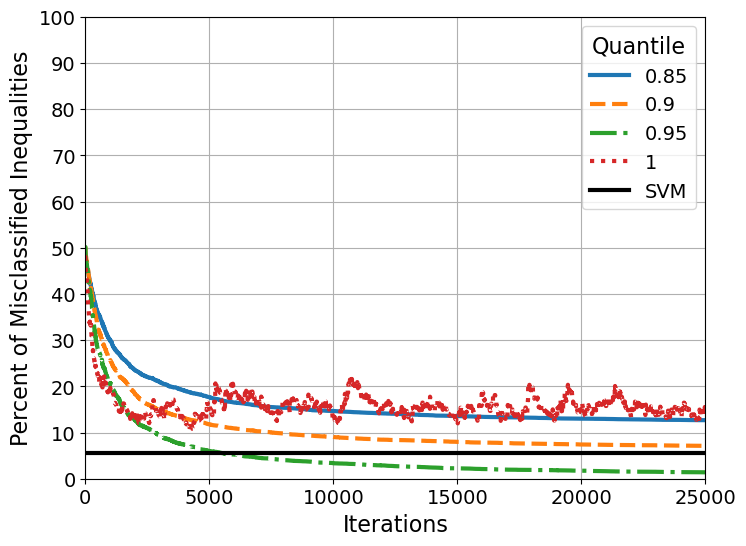

In [20]:
line_styles = ['-', '--', '-.', ':']
plt.figure(figsize=(8, 6))
for idx, residuals in enumerate(residual_list):
    x = np.arange(len(residuals))
    plt.plot(x, residuals, label=f'{quantile_list[idx]}', linestyle=line_styles[idx], linewidth=3)
    
plt.axhline(y=(1 - accuracy) * 100, color='black', linestyle='-', linewidth=3, label='SVM')
plt.xlim(0, numIterations)
plt.ylim(bottom=0)
plt.yticks(np.arange(0, 110, 10), fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Quantile', fontsize=14, title_fontsize=16)  # Increase legend title font size
plt.grid(True)
plt.savefig('beta_equals_0.05.png', dpi=300, bbox_inches='tight')
plt.show()

# Sampled Indices: Timing them


In [21]:
sampled_indices_list = [1000, 25000, 50000]

In [22]:
residual_list = []  # Residual times for each sampled index
residual_errors = []  # Residual errors for each sampled index
residual_dict = {}  # Dictionary to store residual_list for each t value
error_dict = {}  # Dictionary to store residual_errors for each t value
q = 1-fraction_corrupted
trials = 5
numIters = 25000

for t in sampled_indices_list:
    residual_list_i = []
    residual_errors_i = []
    for i in range(trials):
        x, residuals, residuals_time = perceptronModified(data, labels, q, t, numIters, correct_labels, numMislabelled, numDataPoints)
        residual_list_i.append(residuals_time)
        residual_errors_i.append(residuals)
    # Average the results for this sampled index across the iterations
    avg_residual_time = np.mean(residual_list_i, axis=0)
    avg_residual_error = np.mean(residual_errors_i, axis=0)

    # Append to the overall list
    residual_list.append(avg_residual_time)
    residual_errors.append(avg_residual_error)

    # Store the average residual times and errors for this t value in the corresponding dictionaries
    residual_dict[t] = avg_residual_time
    error_dict[t] = avg_residual_error

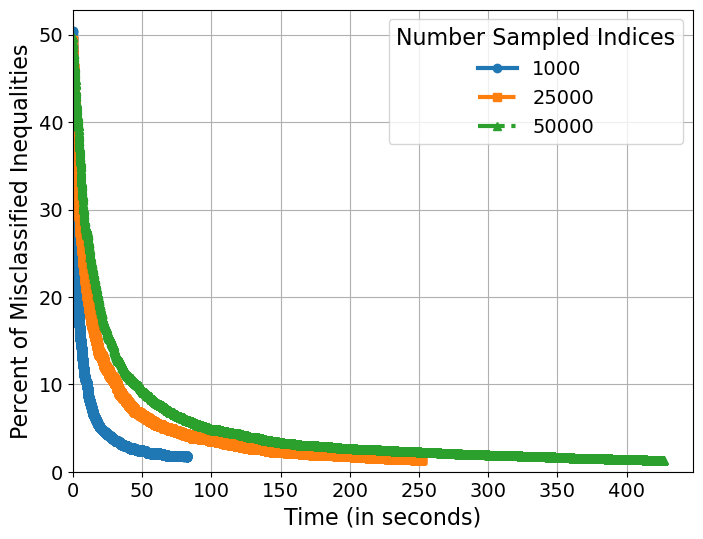

In [23]:
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(8, 6))
for idx, t in enumerate(sampled_indices_list):
    x_values = residual_dict[t]
    y_values = error_dict[t]
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    plt.plot(x_values, y_values, label=f'{t}', linestyle=line_style, marker=marker, linewidth=3)

plt.xlabel('Time (in seconds)', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Number Sampled Indices', fontsize=14, title_fontsize=16, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, which='both', axis='both')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.savefig('time_sampled_indices_q_equals_0.95.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()

# $\beta = 0.10$ Experiments

# Synthesize the normally distributed data set

In [24]:
# Synthesize 2D data points and normalize them
numDataPoints = 50000
numFeatures = 100
data = np.random.normal(0, 1, size=(numFeatures, numDataPoints))  # Mean=0, S.D. = 1, generates a 100x50000 array
# Normalize the data
for i in range(data.shape[1]):
    data[:, i] = data[:, i] / np.linalg.norm(data[:, i])

In [25]:
# True decision boundary separating the 2 classes of data
w_true = np.random.normal(0, 1, size=(numFeatures, 1))

# Identify points on either side of the line {x: w_true^T x = 0}
labels = np.zeros((1, data.shape[1]))
for col_ind in range(data.shape[1]):
    if np.dot(data[:, col_ind], w_true) < 0:
        labels[0, col_ind] = -1
    else:
        labels[0, col_ind] = 1

correct_labels = labels.copy()
# Create a dictionary with the data points and their labels
original_data_dict = {}
for i in range(data.shape[1]):
    key = tuple(data[:, i])
    value = labels[0, i]
    original_data_dict[key] = value

In [26]:
'''Mislabel points'''

# Number of mislabelled points
numMislabelled = 5000

fraction_corrupted = numMislabelled / data.shape[1]
print(f"Fraction corrupted: {fraction_corrupted}")

indices = np.where(labels[0] == 1)[0]  # Find indices where labels are 1
# Mislabel the first `numMislabelled` points from the positive class
mislabelled_indices = indices[:numMislabelled]
labels[0, mislabelled_indices] = -1

# Now, create a dictionary that includes all data points with their possibly mislabelled labels
mislabelled_data_dict = {}

# Store the mislabelled data points in the dictionary
for i in range(data.shape[1]):
    key = tuple(data[:, i])  # Use tuple of the data point as the key
    value = labels[0, i]  # Corresponding label (either 1 or -1)
    mislabelled_data_dict[key] = value

mislabelled_points = {key: value for key, value in mislabelled_data_dict.items() if value == -1}
new_labels = np.array(list(original_data_dict.values()))

Fraction corrupted: 0.1


In [27]:
correct_labels = correct_labels.reshape(-1) # essential line to reshape array
labels = labels.reshape(-1) # essential line to reshape array

In [28]:
y_test = correct_labels
X_train, y_train = data.T, labels
svm_model = LinearSVC(dual=False)
svm_model.fit(X_train, y_train)
w = svm_model.coef_[0]
b = svm_model.intercept_[0]
# Manually calculate predictions for X_test using the decision function
y_pred = np.sign(np.dot(X_train, w) + b)  # Decision function: w * X + b
difference_mask = np.where(correct_labels == labels)  # Only retain the spots where they are equal
y_predUncorrupted = y_pred[difference_mask]
y_testUncorrupted = y_test[difference_mask]
# Now compare these predictions to the true labels (y_test)
accuracy = accuracy_score(y_predUncorrupted, y_testUncorrupted)
# Print results
print("Manual predictions:", y_predUncorrupted)
print("True labels (y_test):", y_testUncorrupted)
print("Accuracy:", accuracy)

Manual predictions: [-1. -1. -1. ... -1. -1.  1.]
True labels (y_test): [-1. -1. -1. ...  1. -1.  1.]
Accuracy: 0.8896888888888889


# Function call and error plot

In [29]:
quantile_list = [0.85, 0.9, 0.95, 1]
residual_list = []

numTrials = 5
numIterations = 25000
for q in quantile_list:
  intermediateResiduals = []
  for i in range(numTrials):
      x, residuals, _ = perceptronModified(data, labels, q, numDataPoints, numIterations, correct_labels, numMislabelled, numDataPoints)
      intermediateResiduals.append(residuals)
  intermediateResiduals = np.mean(intermediateResiduals, axis = 0)
  residual_list.append(intermediateResiduals)  # Store residuals for each quantile

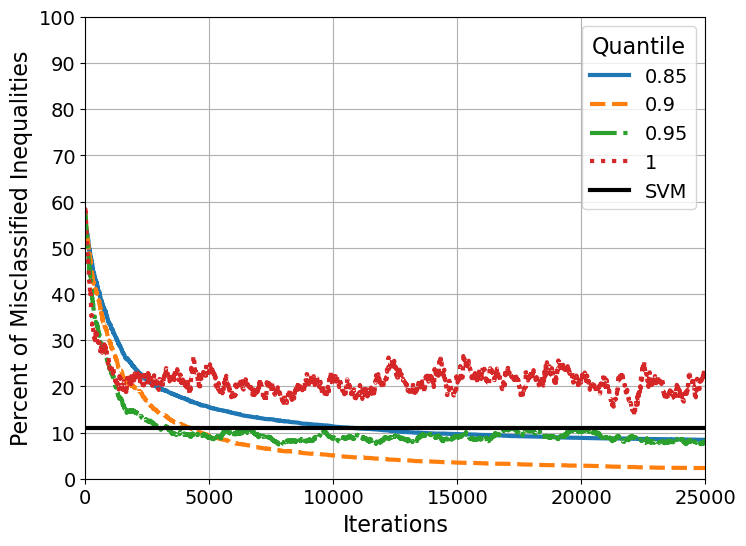

In [30]:
line_styles = ['-', '--', '-.', ':']
plt.figure(figsize=(8, 6))
for idx, residuals in enumerate(residual_list):
    x = np.arange(len(residuals))
    plt.plot(x, residuals, label=f'{quantile_list[idx]}', linestyle=line_styles[idx], linewidth=3)
plt.axhline(y=(1 - accuracy) * 100, color='black', linestyle='-', linewidth=3, label='SVM')
plt.xlim(0, numIterations)
plt.ylim(bottom=0)
plt.yticks(np.arange(0, 110, 10), fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Quantile', fontsize=14, title_fontsize=16)  # Increase legend title font size
plt.grid(True)
plt.savefig('beta_equals_0.10.png', dpi=300, bbox_inches='tight')
plt.show()

# Sampled Indices: Timing them


In [31]:
sampled_indices_list = [1000, 25000, 50000]

In [32]:
residual_list = []  # Residual times for each sampled index
residual_errors = []  # Residual errors for each sampled index
residual_dict = {}  # Dictionary to store residual_list for each t value
error_dict = {}  # Dictionary to store residual_errors for each t value
q = 1-fraction_corrupted
trials = 5
numIters = 25000

for t in sampled_indices_list:
    residual_list_i = []
    residual_errors_i = []
    for i in range(trials):
        x, residuals, residuals_time = perceptronModified(data, labels, q, t, numIters, correct_labels, numMislabelled, numDataPoints)
        residual_list_i.append(residuals_time)
        residual_errors_i.append(residuals)
    # Average the results for this sampled index across the iterations
    avg_residual_time = np.mean(residual_list_i, axis=0)
    avg_residual_error = np.mean(residual_errors_i, axis=0)

    # Append to the overall list
    residual_list.append(avg_residual_time)
    residual_errors.append(avg_residual_error)

    # Store the average residual times and errors for this t value in the corresponding dictionaries
    residual_dict[t] = avg_residual_time
    error_dict[t] = avg_residual_error

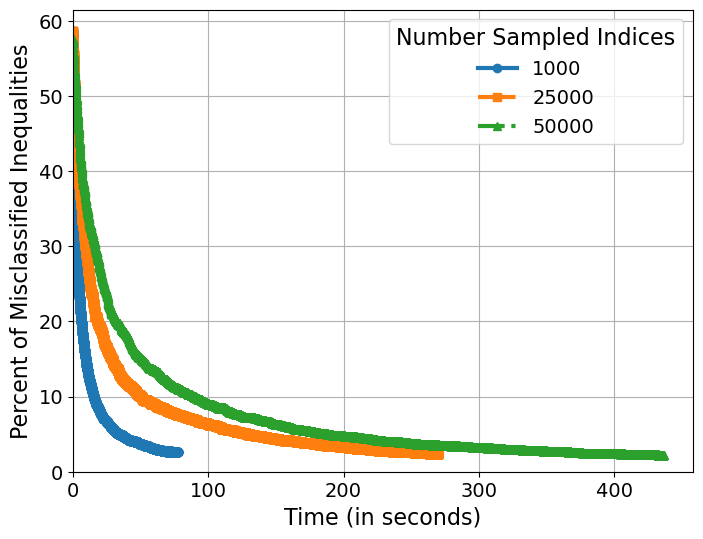

In [33]:
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(8, 6))
for idx, t in enumerate(sampled_indices_list):
    x_values = residual_dict[t]
    y_values = error_dict[t]
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    plt.plot(x_values, y_values, label=f'{t}', linestyle=line_style, marker=marker, linewidth=3)

plt.xlabel('Time (in seconds)', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Number Sampled Indices', fontsize=14, title_fontsize=16, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, which='both', axis='both')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.savefig('time_sampled_indices_q_equals_0.90.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()

# $\beta = 0.20$ Experiments

# Synthesize the normally distributed data set

In [34]:
# Synthesize 2D data points and normalize them
numDataPoints = 50000
numFeatures = 100
data = np.random.normal(0, 1, size=(numFeatures, numDataPoints))  # Mean=0, S.D. = 1, generates a 100x50000 array
# Normalize the data
for i in range(data.shape[1]):
    data[:, i] = data[:, i] / np.linalg.norm(data[:, i])

In [35]:
# True decision boundary separating the 2 classes of data
w_true = np.random.normal(0, 1, size=(numFeatures, 1))

# Identify points on either side of the line {x: w_true^T x = 0}
labels = np.zeros((1, data.shape[1]))
for col_ind in range(data.shape[1]):
    if np.dot(data[:, col_ind], w_true) < 0:
        labels[0, col_ind] = -1
    else:
        labels[0, col_ind] = 1

correct_labels = labels.copy()
# Create a dictionary with the data points and their labels
original_data_dict = {}
for i in range(data.shape[1]):
    key = tuple(data[:, i])
    value = labels[0, i]
    original_data_dict[key] = value

In [36]:
'''Mislabel points'''

# Number of mislabelled points
numMislabelled = 10000

fraction_corrupted = numMislabelled / data.shape[1]
print(f"Fraction corrupted: {fraction_corrupted}")

indices = np.where(labels[0] == 1)[0]  # Find indices where labels are 1
# Mislabel the first `numMislabelled` points from the positive class
mislabelled_indices = indices[:numMislabelled]
labels[0, mislabelled_indices] = -1

# Now, create a dictionary that includes all data points with their possibly mislabelled labels
mislabelled_data_dict = {}

# Store the mislabelled data points in the dictionary
for i in range(data.shape[1]):
    key = tuple(data[:, i])  # Use tuple of the data point as the key
    value = labels[0, i]  # Corresponding label (either 1 or -1)
    mislabelled_data_dict[key] = value

mislabelled_points = {key: value for key, value in mislabelled_data_dict.items() if value == -1}
new_labels = np.array(list(original_data_dict.values()))

Fraction corrupted: 0.2


In [37]:
correct_labels = correct_labels.reshape(-1) # essential line to reshape array
labels = labels.reshape(-1) # essential line to reshape array

In [38]:
y_test = correct_labels
X_train, y_train = data.T, labels
svm_model = LinearSVC(dual=False)
svm_model.fit(X_train, y_train)
w = svm_model.coef_[0]
b = svm_model.intercept_[0]
# Manually calculate predictions for X_test using the decision function
y_pred = np.sign(np.dot(X_train, w) + b)  # Decision function: w * X + b
difference_mask = np.where(correct_labels == labels)  # Only retain the spots where they are equal
y_predUncorrupted = y_pred[difference_mask]
y_testUncorrupted = y_test[difference_mask]
# Now compare these predictions to the true labels (y_test)
accuracy = accuracy_score(y_predUncorrupted, y_testUncorrupted)
# Print results
print("Manual predictions:", y_predUncorrupted)
print("True labels (y_test):", y_testUncorrupted)
print("Accuracy:", accuracy)

Manual predictions: [-1. -1. -1. ... -1. -1.  1.]
True labels (y_test): [-1. -1. -1. ... -1.  1.  1.]
Accuracy: 0.7913


# Function call and error plot

In [39]:
quantile_list = [0.75, 0.8, 0.9, 1]
residual_list = []

numTrials = 5
numIterations = 25000
for q in quantile_list:
  intermediateResiduals = []
  for i in range(numTrials):
      x, residuals, _ = perceptronModified(data, labels, q, numDataPoints, numIterations, correct_labels, numMislabelled, numDataPoints)
      intermediateResiduals.append(residuals)
  intermediateResiduals = np.mean(intermediateResiduals, axis = 0)
  residual_list.append(intermediateResiduals)  # Store residuals for each quantile

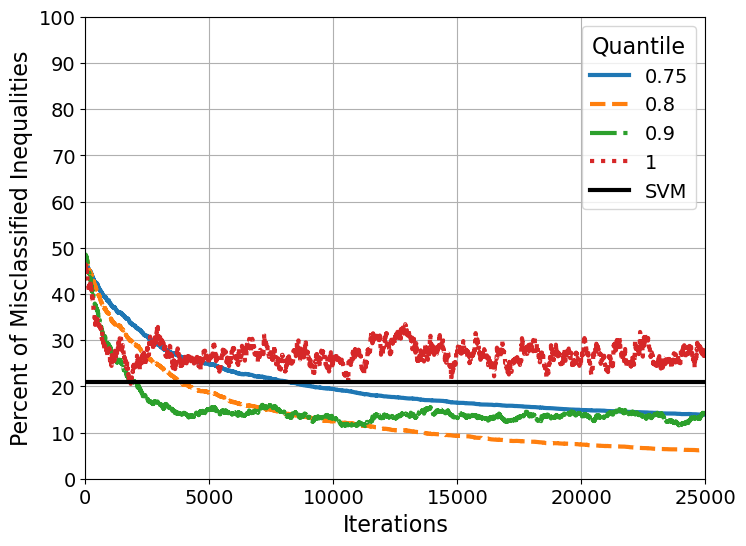

In [40]:
line_styles = ['-', '--', '-.', ':']
plt.figure(figsize=(8, 6))
for idx, residuals in enumerate(residual_list):
    x = np.arange(len(residuals))
    plt.plot(x, residuals, label=f'{quantile_list[idx]}', linestyle=line_styles[idx], linewidth=3)
    
plt.axhline(y=(1 - accuracy) * 100, color='black', linestyle='-', linewidth=3, label='SVM')
plt.xlim(0, numIterations)
plt.ylim(bottom=0)
plt.yticks(np.arange(0, 110, 10), fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Quantile', fontsize=14, title_fontsize=16)  # Increase legend title font size
plt.grid(True)
plt.savefig('beta_equals_0.20.png', dpi=300, bbox_inches='tight')
plt.show()

# Sampled Indices: Timing them


In [41]:
sampled_indices_list = [1000, 25000, 50000]

In [42]:
residual_list = []  # Residual times for each sampled index
residual_errors = []  # Residual errors for each sampled index
residual_dict = {}  # Dictionary to store residual_list for each t value
error_dict = {}  # Dictionary to store residual_errors for each t value
q = 1-fraction_corrupted
trials = 5
numIters = 25000

for t in sampled_indices_list:
    residual_list_i = []
    residual_errors_i = []
    for i in range(trials):
        x, residuals, residuals_time = perceptronModified(data, labels, q, t, numIters, correct_labels, numMislabelled, numDataPoints)
        residual_list_i.append(residuals_time)
        residual_errors_i.append(residuals)
    # Average the results for this sampled index across the iterations
    avg_residual_time = np.mean(residual_list_i, axis=0)
    avg_residual_error = np.mean(residual_errors_i, axis=0)

    # Append to the overall list
    residual_list.append(avg_residual_time)
    residual_errors.append(avg_residual_error)

    # Store the average residual times and errors for this t value in the corresponding dictionaries
    residual_dict[t] = avg_residual_time
    error_dict[t] = avg_residual_error

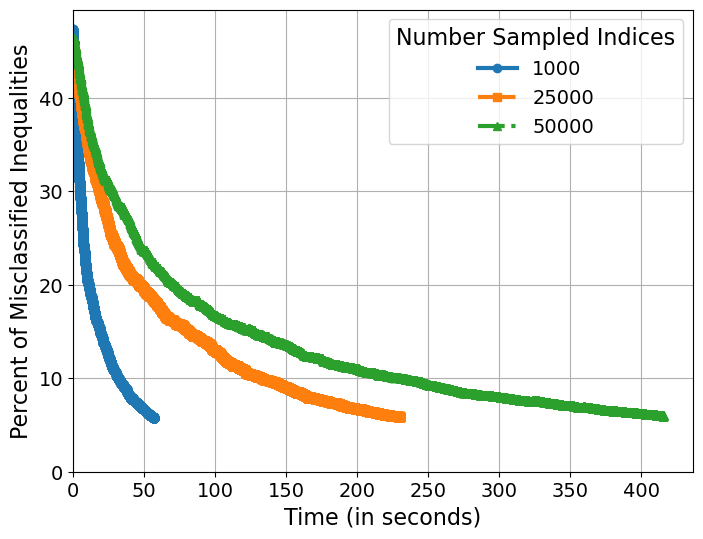

In [43]:
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', '^', 'D']

plt.figure(figsize=(8, 6))
for idx, t in enumerate(sampled_indices_list):
    x_values = residual_dict[t]
    y_values = error_dict[t]
    line_style = line_styles[idx % len(line_styles)]
    marker = markers[idx % len(markers)]
    plt.plot(x_values, y_values, label=f'{t}', linestyle=line_style, marker=marker, linewidth=3)

plt.xlabel('Time (in seconds)', fontsize=16)
plt.ylabel('Percent of Misclassified Inequalities', fontsize=16)
plt.legend(title='Number Sampled Indices', fontsize=14, title_fontsize=16, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, which='both', axis='both')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.savefig('time_sampled_indices_q_equals_0.80.png', dpi=300, bbox_inches='tight')  # Save with high resolution
plt.show()